In [1]:
# Common imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [2]:
# Import from utils
import sys
import importlib
sys.path.append('../')

import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\USUARIO\\Desktop\\Projects\\4Geeks_temporal_series\\src\\lake\\..\\utils.py'>

In [3]:
df = pd.read_csv('../../data/processed/lake_bilancino.csv')
df = df.sort_values(by=["Date"])
df

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,2002-06-03,0.0,0.0,0.4,0.0,0.0,6.50,249.43,0.31
1,2002-06-04,0.0,0.0,0.4,0.0,0.0,6.50,249.43,0.31
2,2002-06-05,0.0,0.0,0.4,0.0,0.0,6.50,249.43,0.31
3,2002-06-06,0.0,0.0,0.4,0.0,0.0,6.50,249.43,0.31
4,2002-06-07,0.0,0.0,0.4,0.0,0.0,6.50,249.44,0.31
...,...,...,...,...,...,...,...,...,...
6598,2020-06-26,0.0,0.0,0.0,0.0,0.0,22.50,250.85,0.60
6599,2020-06-27,0.0,0.0,0.0,0.0,0.0,23.40,250.84,0.60
6600,2020-06-28,0.0,0.0,0.0,0.0,0.0,21.50,250.83,0.60
6601,2020-06-29,0.0,0.0,0.0,0.0,0.0,23.20,250.82,0.60


# Modelado

In [4]:
utils.get_null_percentage_per_column(df)

Date                    0.0
Rainfall_S_Piero        0.0
Rainfall_Mangona        0.0
Rainfall_S_Agata        0.0
Rainfall_Cavallina      0.0
Rainfall_Le_Croci       0.0
Temperature_Le_Croci    0.0
Lake_Level              0.0
Flow_Rate               0.0
dtype: float64

In [5]:
# Selección de variables
target_col = "Lake_Level"
feature_cols = [col for col in df.columns if col not in ["Date", target_col]]

In [6]:
# Normalización
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,2002-06-03,-0.352911,-0.356298,-0.301305,-0.33202,-0.370158,-1.045234,249.43,-0.604750
1,2002-06-04,-0.352911,-0.356298,-0.301305,-0.33202,-0.370158,-1.045234,249.43,-0.604750
2,2002-06-05,-0.352911,-0.356298,-0.301305,-0.33202,-0.370158,-1.045234,249.43,-0.604750
3,2002-06-06,-0.352911,-0.356298,-0.301305,-0.33202,-0.370158,-1.045234,249.43,-0.604750
4,2002-06-07,-0.352911,-0.356298,-0.301305,-0.33202,-0.370158,-1.045234,249.44,-0.604750
...,...,...,...,...,...,...,...,...,...
6598,2020-06-26,-0.352911,-0.356298,-0.359480,-0.33202,-0.370158,1.237181,250.85,-0.533781
6599,2020-06-27,-0.352911,-0.356298,-0.359480,-0.33202,-0.370158,1.365567,250.84,-0.533781
6600,2020-06-28,-0.352911,-0.356298,-0.359480,-0.33202,-0.370158,1.094530,250.83,-0.533781
6601,2020-06-29,-0.352911,-0.356298,-0.359480,-0.33202,-0.370158,1.337036,250.82,-0.533781


In [7]:
# Dividir datos en entrenamiento y prueba (80%-20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
# Preparar datos para LSTM
def create_sequences(data, target_col, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length][feature_cols].values)
        y.append(data.iloc[i + seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, target_col, seq_length)
X_test, y_test = create_sequences(test, target_col, seq_length)

In [9]:
# Construcción del modelo LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 38834.7500 - val_loss: 31.4446
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 213.9076 - val_loss: 3.0269
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 213.9726 - val_loss: 5.6304
Epoch 4/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 207.8326 - val_loss: 4.3679
Epoch 5/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 203.0189 - val_loss: 6.2134
Epoch 6/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 225.2715 - val_loss: 4.3947
Epoch 7/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 214.3403 - val_loss: 4.0082
Epoch 8/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 211.6361 - val_loss: 4.1580
Epoch 9/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 214.5325 - val_loss: 10.1487
Epoch 10/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 216.3388 - val_loss: 3.2403
Epoch 11/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 220.0284 - val_loss: 6.6703
Epoc

# Evaluación del modelo

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
MAE: 3.6107, RMSE: 3.8308


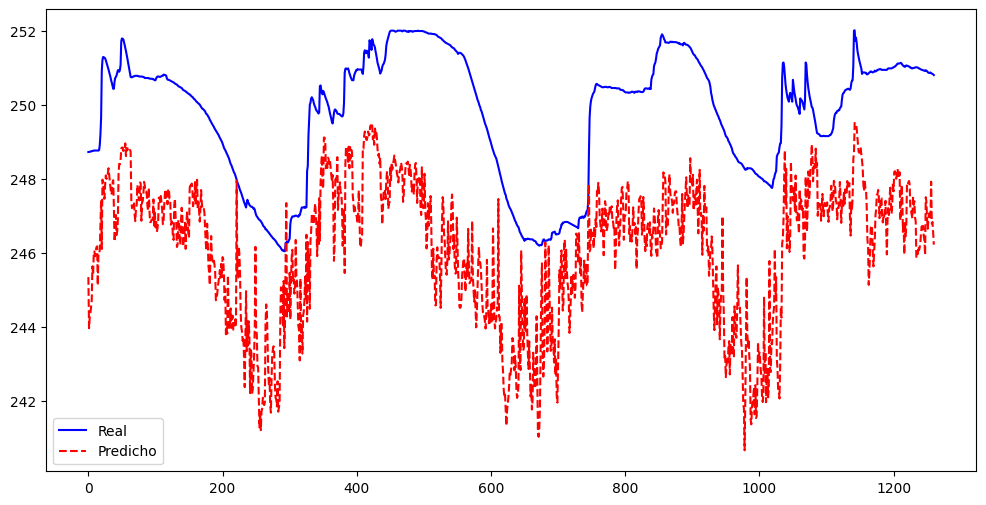

In [11]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color="blue")
plt.plot(y_pred, label="Predicho", color="red", linestyle="dashed")
plt.legend()
plt.show()
